In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split

In [3]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint

In [4]:
import pandas as pd
import numpy as np
import gc

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import pytorch_lightning as pl
import torch.nn.functional as F
from pytorch_lightning.callbacks import Callback
from sklearn.model_selection import KFold
from torch.utils.data import DataLoader, TensorDataset, Subset
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint

In [5]:
%matplotlib inline  

In [6]:
torch.cuda.is_available()

True

In [7]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    not_device = torch.device('cpu')
else:
    device = torch.device('cpu')
    not_device = torch.device('cuda')

In [10]:
# load the data
trainPwd = './MATH5470/train.csv'
train_df = pd.read_csv(trainPwd)
train_df.head()

,row_id,time_id,investment_id,target,f_0,f_1,f_2,f_3,f_4,f_5,...,f_290,f_291,f_292,f_293,f_294,f_295,f_296,f_297,f_298,f_299
0,0_1,0,1,-0.300875,0.932573,0.113691,-0.402206,0.378386,-0.203938,-0.413469,...,0.366028,-1.095620,0.200075,0.819155,0.941183,-0.086764,-1.087009,-1.044826,-0.287605,0.321566
1,0_2,0,2,-0.231040,0.810802,-0.514115,0.742368,-0.616673,-0.194255,1.771210,...,-0.154193,0.912726,-0.734579,0.819155,0.941183,-0.387617,-1.087009,-0.929529,-0.974060,-0.343624
2,0_6,0,6,0.568807,0.393974,0.615937,0.567806,-0.607963,0.068883,-1.083155,...,-0.138020,0.912726,-0.551904,-1.220772,-1.060166,-0.219097,-1.087009,-0.612428,-0.113944,0.243608
3,0_7,0,7,-1.064780,-2.343535,-0.011870,1.874606,-0.606346,-0.586827,-0.815737,...,0.382201,0.912726,-0.266359,-1.220772,0.941183,-0.609113,0.104928,-0.783423,1.151730,-0.773309
4,0_8,0,8,-0.531940,0.842057,-0.262993,2.330030,-0.583422,-0.618392,-0.742814,...,-0.170365,0.912726,-0.741355,-1.220772,0.941183,-0.588445,0.104928,0.753279,1.345611,-0.737624


In [11]:
indexPwd = './MATH5470/validation_indexes.csv'
validate_df = pd.read_csv(indexPwd)
validate_df.head()
newValidateArray = validate_df['Index'].values
newTrainArray = np.setdiff1d(np.arange(0, train_df.shape[0]), newValidateArray)
validateDf = train_df.iloc[newValidateArray]
train_df = train_df.iloc[newTrainArray]

Index(['f_0', 'f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8', 'f_9',
       ...
       'f_290', 'f_291', 'f_292', 'f_293', 'f_294', 'f_295', 'f_296', 'f_297',
       'f_298', 'f_299'],
      dtype='object', length=300)

In [12]:
train = train_df
float_feature_names = train.drop(['target', 'row_id', 'time_id', 'investment_id'], axis=1).columns
float_input = train[float_feature_names].values
investment_id = train[['investment_id']].values.astype(int)
time_id = train[['time_id']].values.astype(int)
targets = train[['target']].values

del train


In [13]:
# everything as torch tensors
torch.cuda.empty_cache() 
float_input = torch.FloatTensor(float_input)
investment_id = torch.LongTensor(investment_id)
time_id = torch.LongTensor(time_id)
target = torch.FloatTensor(targets)
dataset = TensorDataset(time_id, investment_id, float_input, target)

gc.collect()

123

In [14]:
def my_loss(output, target):
    # pearson loss function
    x = output
    y = target
    vx = x - torch.mean(x)
    vy = y - torch.mean(y)
    cost = torch.sum(vx * vy) / (torch.sqrt(torch.sum(vx ** 2)) * torch.sqrt(torch.sum(vy ** 2)))
    return 1-cost

In [15]:
class UbiquantRegressor(pl.LightningModule):
    def __init__(self):
        super(UbiquantRegressor, self).__init__()

        # Embedding of investment_id to 11 float features.
        # As the number of unseen investment_ids is unknown, a large margin is selected (10000). 
        self.id_embedding = nn.Embedding(10000,11)

        # credits to sahil112: https://www.kaggle.com/sahil112/whyonlykeras-easy-pytorch-competitive-dnn for this architecture
        self.layers = nn.Sequential(nn.Linear(311, 64),
                                    nn.BatchNorm1d(64),
                                    nn.SiLU(),
                                    nn.Dropout(0.4),

                                    nn.Linear(64, 128),
                                    nn.BatchNorm1d(128),
                                    nn.SiLU(),
                                    nn.Dropout(0.4),

                                    nn.Linear(128, 256),
                                    nn.BatchNorm1d(256),
                                    nn.SiLU(),
                                    nn.Dropout(0.4),

#                                     nn.Linear(256, 512),
#                                     nn.BatchNorm1d(512),
#                                     nn.SiLU(0.1),
#                                     nn.Dropout(0.4),

#                                     nn.Linear(512, 256),
#                                     nn.BatchNorm1d(256),
#                                     nn.SiLU(),
#                                     nn.Dropout(0.4),

                                    nn.Linear(256, 128),
                                    nn.BatchNorm1d(128),
                                    nn.SiLU(0.1),
                                    nn.Dropout(0.4),

                                    nn.Linear(128, 8),
                                    nn.BatchNorm1d(8),
                                    nn.SiLU(),
                                    nn.Dropout(0.4),

                                    nn.Linear(8, 1))

    def forward(self, time_id, investment_id, f_features):
        # Embedding of the investment_id
        invest_embedding = self.id_embedding(investment_id).squeeze(dim=1)
        # Concat embedding and features.
        # Open question: should the network have access to the time_id?
        # The final test set will consist of time_id never seen in the train set 
        # Nevertheless, it can be easily added here...
        #dnn_input = torch.cat((invest_embedding, time_id, f_features), axis=-1)
        dnn_input = torch.cat((invest_embedding, f_features), axis=-1)
        return self.layers(dnn_input)

    def training_step(self, batch, batch_nb):
        time_id, investment_id, float_input, target = batch

        out = self(time_id, investment_id, float_input)
        loss = my_loss(out, target)

        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_nb):
        time_id, investment_id, float_input, target = batch

        result = self(time_id, investment_id, float_input)
        loss = my_loss(result, target)

        dict = {'val_loss': loss,
                'result': result,
                'target': target,
                'time_id': time_id,
                'investment_id': investment_id,
                }
        return dict

    def validation_epoch_end(self, outputs):
        val_losses = [x['val_loss'] for x in outputs]
        result = torch.cat([x['result'] for x in outputs])
        target = torch.cat([x['target'] for x in outputs])
        time_ids = torch.cat([x['time_id'] for x in outputs])
        investment_ids = torch.cat([x['investment_id'] for x in outputs])

        corrs = []
        for t in torch.unique(time_ids):
            t_results = result[time_ids == t]
            t_target = target[time_ids == t]
            # corr = torch.corrcoef(torch.stack((t_results, t_target)))[0,1] # use this when pytorch>=1.10
            corr = np.corrcoef(torch.stack((t_results, t_target)).cpu().numpy())[0, 1]
            corrs.append(corr)

        # mean_corr = torch.mean(torch.stack(corrs)) # use this when pytorch>=1.10
        mean_corr = np.nanmean(corrs)
        epoch_loss = torch.stack(val_losses).mean()  # Combine losses

        self.log('val_loss', epoch_loss, prog_bar=True)
        self.log('mean_corr', mean_corr, prog_bar=True)

        dict = {'val_loss': epoch_loss,
                'corrs': mean_corr}
        return dict

    def epoch_end(self, epoch, result):
        pass

    def test_step(self, batch, batch_nb):
        pass

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.001)

In [16]:
class MetricTracker(Callback):
    def __init__(self):
        self.val_losses = []
        self.corrs = []

    def on_validation_epoch_end(self, trainer, module):
        self.val_losses.append(trainer._results['validation_epoch_end.val_loss'].value.cpu().numpy()) # track them
        self.corrs.append(trainer._results['validation_epoch_end.mean_corr'].value.cpu().numpy()) # track them
        if 0: #index==1:
            # live plotting of results during training, switched off
            ax.plot(self.val_losses, color="orange")
            ax.set_ylabel("Val loss", color="orange", fontsize=14)
            ax2 = ax.twinx()
            ax2.plot(self.corrs, color="blue")
            ax2.set_ylabel("Mean daily corr 2 target", color="blue", fontsize=14)
            plt.show()

CV run 1...


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/jligm/.local/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:608: UserWarning: Checkpoint directory /scratch/PI/jgwang/jligm/course/MATH5470/lightning_logs/version_619929/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]

  | Name         | Type       | Params
--------------------------------------------
0 | id_embedding | Embedding  | 110 K 
1 | layers       | Sequential | 96.4 K
--------------------------------------------
206 K     Trainable params
0         Non-trainable params
206 K     Total params
0.826     Total estimated model params size (MB)
/home/jligm/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The datalo

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
/home/jligm/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(



────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────
        mean_corr           0.1488582342863083
        val_loss            0.8486170768737793
────────────────────────────────────────────────────────────────────────────────────────────


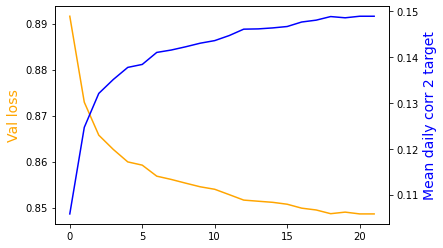

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/jligm/.local/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:608: UserWarning: Checkpoint directory /scratch/PI/jgwang/jligm/course/MATH5470/lightning_logs/version_619929/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]

  | Name         | Type       | Params
--------------------------------------------
0 | id_embedding | Embedding  | 110 K 
1 | layers       | Sequential | 96.4 K
--------------------------------------------
206 K     Trainable params
0         Non-trainable params
206 K     Total params
0.826     Total estimated model params size (MB)


CV run 2...


/home/jligm/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/jligm/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1927: PossibleUserWarning: The number of training batches (48) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(
/home/jligm/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


/home/jligm/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(



────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────
        mean_corr           0.15342211723327637
        val_loss            0.8451476097106934
────────────────────────────────────────────────────────────────────────────────────────────


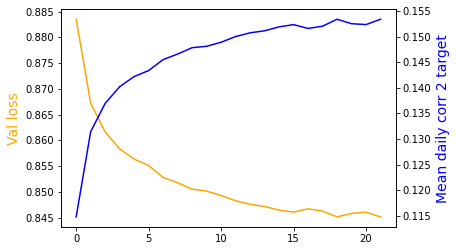

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/jligm/.local/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:608: UserWarning: Checkpoint directory /scratch/PI/jgwang/jligm/course/MATH5470/lightning_logs/version_619929/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]

  | Name         | Type       | Params
--------------------------------------------
0 | id_embedding | Embedding  | 110 K 
1 | layers       | Sequential | 96.4 K
--------------------------------------------
206 K     Trainable params
0         Non-trainable params
206 K     Total params
0.826     Total estimated model params size (MB)


CV run 3...


/home/jligm/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/jligm/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1927: PossibleUserWarning: The number of training batches (48) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(
/home/jligm/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


/home/jligm/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(



────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────
        mean_corr           0.14842209219932556
        val_loss            0.8491424322128296
────────────────────────────────────────────────────────────────────────────────────────────


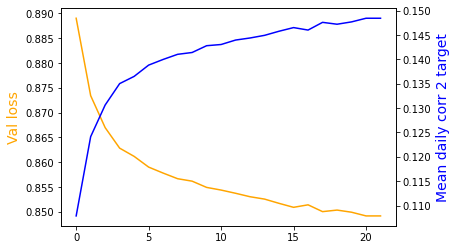

In [17]:
n_splits=3
kf = KFold(n_splits=n_splits, shuffle=True)
val_losses = []
mean_corrs = []
models = [] # A list of all final models
index=0
for train_index, test_index in kf.split(dataset):
    index+=1
    print("CV run {}...".format(index))
    
    train_ds, val_ds = Subset(dataset, train_index), Subset(dataset, test_index)

    train_loader = DataLoader(train_ds, 32768)
    val_loader = DataLoader(val_ds, 32768)

    uq_regressor = UbiquantRegressor()

    metricTracker = MetricTracker()
    trainer = pl.Trainer(gpus=2,
                         callbacks=[metricTracker,
                                    EarlyStopping(monitor="mean_corr", mode="max", patience=3),
                                    ModelCheckpoint(save_top_k=1, monitor="mean_corr", 
                                                    mode="max", save_on_train_epoch_end=False)],
                        strategy="dp",
                         max_epochs=21,
                         num_sanity_val_steps=0,)

    trainer.fit(uq_regressor, train_loader, val_loader)

    # Load best model based on mean daily correlation with target
    uq_regressor = UbiquantRegressor().load_from_checkpoint(trainer.checkpoint_callback.best_model_path)
    models.append(uq_regressor)
    
    # Show val results
    val_result = trainer.validate(model=uq_regressor, dataloaders=val_loader)
    val_losses.append(val_result[0]['val_loss'])
    mean_corrs.append(val_result[0]['mean_corr'])
    fig, ax = plt.subplots()
    ax.plot(metricTracker.val_losses, color="orange")
    ax.set_ylabel("Val loss", color="orange", fontsize=14)
    ax2 = ax.twinx()
    ax2.plot(metricTracker.corrs, color="blue")
    ax2.set_ylabel("Mean daily corr 2 target", color="blue", fontsize=14)
    plt.show()

In [18]:
torch.save(uq_regressor.state_dict(), "./lstm44.pth")

In [19]:
# model = MyLightningModule(hparams)
# trainer.fit(model)
trainer.save_checkpoint("./lstm44.ckpt")
# new_model = MyModel.load_from_checkpoint(checkpoint_path="example.ckpt")

In [24]:
time_idV = validateDf.row_id.str.split("_", expand=True)[0].values.astype(int) 
investment_idV = validateDf[['investment_id']].values.astype(int)
float_inputV = validateDf[float_feature_names].values

float_inputV = torch.FloatTensor(float_inputV)
investment_idV = torch.LongTensor(investment_idV)
time_idV = torch.LongTensor(time_idV).unsqueeze(-1)

In [46]:
sample_prediction_df = []

In [47]:
for uq_regressor in models:
        uq_regressor.eval()
        with torch.no_grad():
            predictions = uq_regressor(time_idV, investment_idV, float_inputV).squeeze()
        sample_prediction_df.append(predictions.detach().cpu().numpy()/n_splits)

In [53]:
# validateDf

In [54]:
# sample_prediction_df[0].shape

In [55]:
# sample_prediction_df[0] + sample_prediction_df[1] + sample_prediction_df[2]

In [56]:
# validateDf['target'].values

In [52]:
np.corrcoef(sample_prediction_df[0] + sample_prediction_df[1] + sample_prediction_df[2],
        validateDf['target'].values)

array([[1.        , 0.14915096],
       [0.14915096, 1.        ]])

In [71]:
time_idV = validateDf.row_id.str.split("_", expand=True)[0].values.astype(int) 
investment_idV = validateDf[['investment_id']].values.astype(int)
float_inputV = validateDf[float_feature_names].values

float_inputV = torch.FloatTensor(float_inputV)
investment_idV = torch.LongTensor(investment_idV)
time_idV = torch.LongTensor(time_idV).unsqueeze(-1)

# use the loaded model
model2 = UbiquantRegressor()
uq_regressor = model2.load_from_checkpoint("./lstm44.ckpt")
uq_regressor.eval()
with torch.no_grad():
    predictions = uq_regressor(time_idV, investment_idV, float_inputV).squeeze()
sample_prediction_df=predictions.detach().cpu().numpy()
np.corrcoef(sample_prediction_df, validateDf['target'].values)

array([[1.        , 0.14695018],
       [0.14695018, 1.        ]])

In [78]:
# models[0] # seems could not save many ckpt

In [ ]:
# The submission part
import ubiquant
env = ubiquant.make_env()
iter_test = env.iter_test() 

model3 = UbiquantRegressor()
uq_regressor = model3.load_from_checkpoint("../input/lstmmodel/lstm44.ckpt")
uq_regressor = model3.load_from_checkpoint("../input/lstmmodel/lstm53_lstm.ckpt")

for (test_df, sample_prediction_df) in iter_test:
    time_id = test_df.row_id.str.split("_", expand=True)[0].values.astype(int) 
    investment_id = test_df[['investment_id']].values.astype(int)
    float_input = test_df[float_feature_names].values
    
    float_input = torch.FloatTensor(float_input)
    investment_id = torch.LongTensor(investment_id)
    time_id = torch.LongTensor(time_id).unsqueeze(-1)
    
    sample_prediction_df['target'] = 0
    
    uq_regressor.eval()
    with torch.no_grad():
        predictions = uq_regressor(time_idV, investment_idV, float_inputV).squeeze()
    sample_prediction_df['target'] += predictions.detach().cpu().numpy()
        
    env.predict(sample_prediction_df) 
    display(sample_prediction_df)